# Colony forming units (cfu) of mold versus air particulate measurements.

Two things I want to explore: 
* Is there a **particle count** difference between locations with **CFU** measurements above below 10?
* Are particulate counts an indicator of CFU counts?

In [31]:
#importing the tools
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

Explore the data relationships of all your features and understand how the
features compare to the response variable.

● Build data profiles and tables

○ Inferential statistics

● Explore data relationships

○ Data visualization

● Feature Selection and Engineering


### Loading data and building profiles

In [44]:
file = 'data\combined_VAS.csv'
df = pd.read_csv(file,index_col=0,parse_dates=True)
df['Date'] = pd.to_datetime(df['Date'])
df['Traffic'] = df['Traffic'].astype('category')
df['Weather'] = df['Weather'].astype('category')
df['cfu'] = df['cfu'].astype('float')
df.reset_index()
df.dtypes

Date                      datetime64[ns]
location                          object
Temp                             float64
RH                               float64
Total_Particles>0.3              float64
Total_Particles>0.5/m3           float64
Traffic                         category
Weather                         category
cfu                              float64
Source                            object
dtype: object

#### CFU 0 values are genuine 0s. CFU 34 values are spiked values as the true value could be > 34

In [45]:
#the values at 34 actually represent 34 and above. during analysis counting stopped at 34
#for this reason I will take out the 34 values as they may not be accurate.
#maybe I can regression and see if they are expected to be 34 or higher based on 
#particulates data
df['location'][df['cfu']==34].value_counts()
df = df[df['cfu']<34]

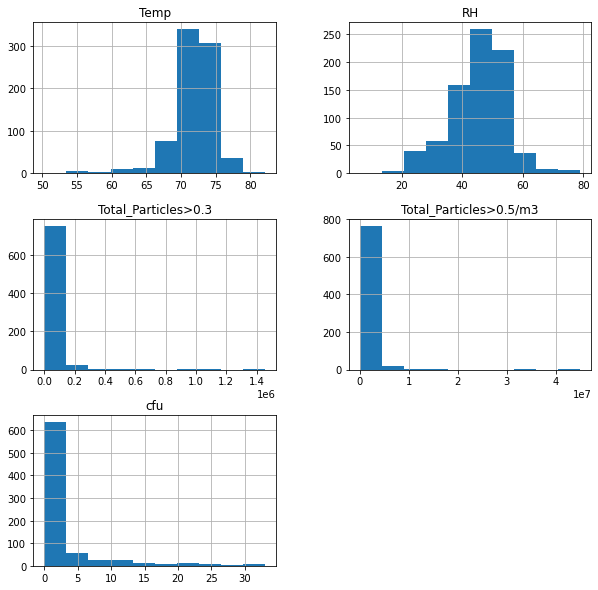

In [46]:
hist = df.hist(bins=10, figsize=(10,10))

#### Adding a threshold value of 10.

In [47]:
df['threshold'] = np.where(df['cfu'] < 10, 'under','over')

#### Seperating the data to only look at indoor values.

In [48]:
outside = 'MBH Shuttle Stop','ED Lot'
df['sample_type'] = np.where(df['location'] == outside, 'outdoor','indoor')
df_indoor = df[df['sample_type']=='indoor']
df_indoor = df_indoor[['Total_Particles>0.3','Total_Particles>0.5/m3',
                'cfu','Source','threshold','location']]
df_indoor.sample(6)

,Total_Particles>0.3,Total_Particles>0.5/m3,cfu,Source,threshold,location
1102,284.0,29601.0,0.0,MB,under,BMT-C6971
957,1417.0,149484.0,0.0,MB,under,BMT-C6S91
2075,3315.0,218493.0,1.0,MB,under,B1-C5
469,24104.0,381802.0,0.0,ML,under,L26
2106,39083.0,1290575.0,0.0,MB,under,BMT-C6S90
1827,20423.0,683887.0,0.0,ML,under,9L NS


### transforming the particulate data to normal

In [49]:
# particle cout numbers are so large that I will scale them down
df_indoor['log03'] = np.log(df_indoor['Total_Particles>0.3'])
df_indoor['log05m3'] = np.log(df_indoor['Total_Particles>0.5/m3'])

logdf = df_indoor[['log03','log05m3','cfu','Source','threshold','location']]
logdf.shape

(793, 6)

##### now the CFU

In [67]:
#lets see if cfu can be normalized
z = np.asarray(logdf['cfu'])
z1 = np.asarray(df_indoor['Total_Particles>0.3'])
z2 = np.asarray(df_indoor['Total_Particles>0.5/m3'])

logdf['zcfu'] = (z - z.mean())/ z.std()
logdf['sqrtcfu'] = np.sqrt(z)
logdf['cbrtcfu'] = np.cbrt(z)
logdf['logcfu'] = np.log((1 + z)/2)
logdf['minmaxcfu'] = (z - z.min()) / (z.max() - z.min())
                
logdf['minmax03'] = (z1 - z1.min()) / (z1.max() - z1.min())
logdf['minmax05m3'] = (z2 - z2.min()) / (z2.max() - z2.min())

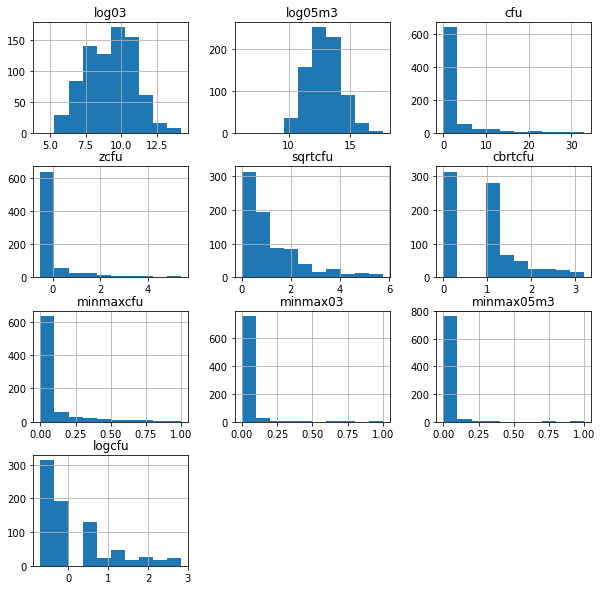

In [68]:
hist = logdf.hist(bins=10, figsize=(10,10))

## Now looking at over and under the 10 CFU threshold

In [73]:
logdf.groupby('threshold').describe()

log03                                                      \
           count       mean       std       min       25%        50%   
threshold                                                              
over        73.0  10.746153  1.447362  7.199678  9.638675  10.896369   
under      720.0   9.093039  1.640065  4.336100  7.730722   9.223701   

                                log05m3             ... minmax05m3            \
                 75%        max   count       mean  ...        75%       max   
threshold                                           ...                        
over       11.767730  13.799796    73.0  14.216956  ...   0.095489  0.342102   
under      10.376351  14.190010   720.0  12.728745  ...   0.017960  1.000000   

          logcfu                                                             \
           count      mean      std       min       25%       50%       75%   
threshold                                                                     
over        73.0  2.202458  0.34422  1.704748  1.945910  2.140066  2.484907   
under      720.0 -0.073578  0.64855 -0.693147 -0.693147  0.000000  0.405465   

                     
                max  
threshold            
over       2.833213  
under      1.609438  

[2 rows x 80 columns]

In [74]:
logdf.groupby('threshold').mean()

,log03,log05m3,cfu,zcfu,sqrtcfu,cbrtcfu,minmaxcfu,minmax03,minmax05m3,logcfu
threshold,,,,,,,,,,
over,10.746153,14.216956,18.191781,2.748423,4.195642,2.591820,0.551266,0.074989,0.066744,2.202458
under,9.093039,12.728745,1.350000,-0.278660,0.817551,0.712717,0.040909,0.021886,0.017675,-0.073578


In [ ]:
transformed_df = 

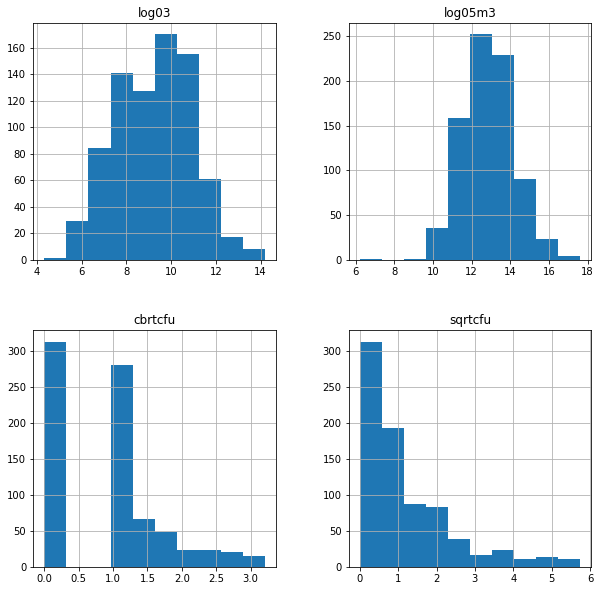

In [55]:
hist = transformed_df.hist(bins=10, figsize=(10,10))

In [14]:
hist = sqrtdf.hist(bins=10, figsize=(10,10))

NameError: name 'sqrtdf' is not defined

In [ ]:
sns.pairplot(df_indoor[['cfu','log05m3','log03']])

#not ready for this

sns.set()

n_data = len(df1['cfu'])
n_bins = np.sqrt(n_data)
n_bins = int(n_bins)

plt.hist(df1['cfu'], bins=n_bins)

n_data = len(df1['cfu'])
n_bins = np.sqrt(n_data)
n_bins = int(n_bins)

plt.xlabel('colony forming units')
plt.ylabel('count')
# Show histogram
plt.show()